In [1]:
import numpy as np
import pandas as pd
import csv
import os
from SepsisCheck import sepsischeck_utilities_for_pkl as su
from sklearn.metrics import precision_recall_fscore_support as score
#from sklearn.metrics import average_precision_score as score
from sklearn.metrics import classification_report as report
from sklearn.metrics import roc_auc_score as auroc
from sklearn.metrics import confusion_matrix

### Take a look at the results of sepsis check on patients

In [2]:
def convert_result_to_df(filename):
    result_dict = []
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            line_list = line.split()
            line_list = [s.strip(',') for s in line_list]
            line_list = [s.replace(',', '') for s in line_list]
            result_dict.append(dict({'Subject ID': line_list[2], 
                                        'Hadm_ID': line_list[4],
                                        'ts_ind': line_list[6],
                                        'Sepsis': line_list[8], 
                                        't_sepsis': line_list[10],
                                        't_sofa': line_list[12], 
                                        't_cultures': line_list[14], 
                                        't_IV': line_list[16], 
                                        't_sus': line_list[18]}))
    df = pd.DataFrame.from_records(result_dict)

    return df

In [3]:
# load data we classified
path = "../data/exp1/forecasting_exp1/mimic_iii_preprocessed_forecasting1.pkl"
preds = "../data/exp1/forecasting_preds/forecasting_preds_test/content/forecasting_preds_test.pkl"
data = pd.read_pickle(path)
preds = pd.read_pickle(preds)
#sort by ts_ind as that is how the results are sorted
data1 = preds[0].sort_values(by=["ts_ind"]).drop_duplicates("ts_ind")
IDs = list(data1["ts_ind"].unique())
#make ground truth for scoring, reset index after sorting. Index 0 -> ts_ind 0
ground_truth = data1[["sepsis_label", "ts_ind"]].reset_index(drop=True) #10498 labels sorted by ts_ind from low to high

#load positive and negative with IV and cultures feature from file, more than 10498 probably -> faster than computing again 
# -> ToDo: Keep only IDs that are in data1 -> smaller than 10498
 
with open("./features/possible_predicitons/forecast_possible_pos_predictions.csv") as f:
    reader = csv.reader(f)
    possible_pos_ = [int(row[0]) for row in reader]
with open("./features/possible_predicitons/forecast_possible_neg_predictions.csv") as f:
    reader = csv.reader(f)
    possible_neg_ = [int(row[0]) for row in reader]

# lists of ts_ind where each item was forecast, but also contained both IV and cultures originally
possible_pos_predictions = list(set(IDs).intersection(set(possible_pos_)))
possible_neg_predictions = list(set(IDs).intersection(set(possible_neg_)))

#indeces of all patients with IV and cultures
all_possible_ = possible_pos_predictions + possible_neg_predictions
all_possible_.sort()

#get labels for all patients that have IV and cultures
adj_ground_truth = ground_truth.loc[ground_truth["ts_ind"].isin(all_possible_)]

ground_truth = ground_truth.sort_values(by=["ts_ind"])
adj_ground_truth = adj_ground_truth.sort_values(by=["ts_ind"])

# df for holding results
col = ["experiment", "t_sepsis", "t_ident", "AUROC", "AUROC_adj","precision_raw", "precision_adj", "recall_raw", "recall_adj", "f1_raw", "f1_adj", "support", "support_adj", "cm", "cm_adj"]
df = pd.DataFrame(columns=col)

In [4]:
def get_t_identification(sofa, IV, cult):
    values =  []
    # for each triplet, get the max -> how much time needs to be observed for a identification
    for i in range(len(sofa)):
        values.append(max(sofa[i], IV[i], cult[i]))
    return sum(values) / len(values)

In [6]:
def compute_results(path):
    # load results and get predicted arrays

    df = convert_result_to_df(path)
    # get mean t_sepsis to compare methods
    df["t_sepsis"] = df["t_sepsis"].replace({"False":np.nan})
    t_sep = df["t_sepsis"].astype(float).mean()

    df["ts_ind"] = df["ts_ind"].astype(int)
    df = df.sort_values(by=["ts_ind"], ascending=True)
    # get indexes of False and True Sepsis labels in results
    noSeps = df.loc[df["Sepsis"] == "False"]
    Seps = df.loc[df["Sepsis"] == "True"]
    neg_hadm_IDs = list(map(int, noSeps["ts_ind"]))
    pos_hadm_IDs = list(map(int, Seps["ts_ind"]))

    # get t of identification of positive labeled patients
    t_ident = get_t_identification(Seps["t_sofa"].astype(float).values, Seps["t_IV"].astype(float).values, Seps["t_cultures"].astype(float).values)
    
    #make predicted df for scoring
    predicted = pd.DataFrame(index=df["ts_ind"], columns=["pred"])
    # 0 for each patient where Sepsis was False
    predicted[predicted.index.isin(neg_hadm_IDs)] = 0
    # 1 for each patient where Sepsis was True
    predicted[predicted.index.isin(pos_hadm_IDs)] = 1
    adj_predicted = predicted.loc[predicted.index.isin(all_possible_)]

    

    # precision, recall f1 (fbeta=1.0) on raw data
    precision, recall, f1_score, support = score(y_true=ground_truth["sepsis_label"].values.astype(int), y_pred=predicted["pred"].values.astype(int), average="weighted")
    auroc_score = auroc(y_true=ground_truth["sepsis_label"].values.astype(int), y_score=predicted["pred"].values.astype(int), average="weighted")
    cm=confusion_matrix(ground_truth["sepsis_label"].values.astype(int), predicted["pred"].values.astype(int)).ravel()
    #print(report(y_true=ground_truth.values.astype(int), y_pred=predicted["pred"].values.astype(int)))

    # precision, recall f1 (fbeta=1.0) on patients that include IV and cultures
    precision_adj, recall_adj, f1_score_adj, support_adj = score(y_true=adj_ground_truth["sepsis_label"].values.astype(int), y_pred=adj_predicted["pred"].values.astype(int), average="weighted")
    auroc_score_adj = auroc(y_true=adj_ground_truth["sepsis_label"].values.astype(int), y_score=adj_predicted["pred"].values.astype(int), average="weighted")
    cm_adj=confusion_matrix(adj_ground_truth["sepsis_label"].values.astype(int), adj_predicted["pred"].values.astype(int)).ravel()

    #print(report(y_true=adj_ground_truth.values.astype(int), y_pred=adj_predicted["pred"].values.astype(int)))

    return  t_sep, t_ident, auroc_score, auroc_score_adj, precision, recall, f1_score, support, precision_adj, recall_adj, f1_score_adj, support_adj, cm, cm_adj

In [8]:
def cleanFilename(sourcestring,  removestring =" %:/,.\\[]<>*?"):
    """Clean a string by removing selected characters.

    Creates a legal and 'clean' source string from a string by removing some 
    clutter and  characters not allowed in filenames.
    A default set is given but the user can override the default string.

    Args:
        | sourcestring (string): the string to be cleaned.
        | removestring (string): remove all these characters from the string (optional).

    Returns:
        | (string): A cleaned-up string.

    Raises:
        | No exception is raised.
    """
    #remove the undesireable characters
    return ''.join([c for c in sourcestring if c not in removestring])



In [ ]:
results_path = "./results/forecast/test/sepsis-3/"
directory = os.fsencode(results_path)
for file in os.listdir(directory):
    name = file.decode('UTF-8')
    t_sepsis, t_ident, auroc_score, auroc_score_adj, precision, recall, f1_score, support, precision_adj, recall_adj, f1_score_adj, support_adj, cm, cm_adj = compute_results(os.path.join(directory, file))
    new_row = {"experiment":name[:-4],"t_sepsis":t_sepsis,"t_ident":t_ident, "AUROC":auroc_score,"AUROC_adj":auroc_score_adj,"precision_raw":precision, "precision_adj":precision_adj, "recall_raw":recall, "recall_adj":recall_adj, "f1_raw":f1_score, "f1_adj":f1_score_adj, "support":support, "support_adj":support_adj, "cm": cm, "cm_adj":cm_adj}
    df2 = df.append(new_row, ignore_index=True)
    df2.to_csv('sepsis-3_forecast_report.csv', mode='a', index=False, header=False)

f1_adj is not good for the different data balance -> models barely able to identify positive patients are performing best.

In [28]:
# tn, fp, fn, tp
results_3 = pd.read_csv("sepsis-3_forecast_report.csv", names=col, header=None)
y = results_3[["experiment", "AUROC_adj", "AUROC","t_ident", "f1_raw", "f1_adj", "precision_adj", "recall_adj","cm_adj", "cm"]].sort_values(["f1_adj"], ascending=False)
y

,experiment,AUROC_adj,AUROC,t_ident,f1_raw,f1_adj,precision_adj,recall_adj,cm_adj,cm
6,cutoffsepsis-3_no-prediction_6-3_1-3,0.520770,0.517557,2.713447,0.861295,0.591088,0.608107,0.668385,[739 49 337 39],[8709 49 919 39]
10,sepsis-3_no-prediction_6-3_1-3,0.520770,0.517557,2.713447,0.861295,0.591088,0.608107,0.668385,[739 49 337 39],[8709 49 919 39]
0,cutoffsepsis-3_no-prediction_24-12_12-24,0.544470,0.571583,8.976296,0.871317,0.587525,0.600357,0.579038,[506 282 208 168],[8476 282 790 168]
1,cutoffsepsis-3_no-prediction_24-12_24-96,0.552921,0.598894,18.695762,0.873090,0.542131,0.611091,0.528351,[381 407 142 234],[8351 407 724 234]
3,cutoffsepsis-3_no-prediction_24-12_48-72,0.565376,0.606853,18.447181,0.874505,0.541128,0.624573,0.529210,[365 423 125 251],[8335 423 707 251]
2,cutoffsepsis-3_no-prediction_24-12_240-240,0.573091,0.620822,25.800545,0.875187,0.511970,0.641348,0.508591,[308 480 92 284],[8278 480 674 284]
9,sepsis-3_no-prediction_48-24_24-72,0.530747,0.601323,21.584531,0.870590,0.497862,0.593103,0.487973,[323 465 131 245],[8293 465 713 245]
5,cutoffsepsis-3_no-prediction_48-24_24-72,0.529417,0.600801,21.442407,0.870441,0.497118,0.591746,0.487113,[323 465 132 244],[8293 465 714 244]
7,sepsis-3_no-prediction_24-12_240-240,0.590203,0.634832,37.196299,0.876760,0.495016,0.674368,0.502577,[270 518 61 315],[8240 518 643 315]
4,cutoffsepsis-3_no-prediction_48-24_168-168,0.543093,0.625364,30.021799,0.871523,0.435242,0.620820,0.451031,[223 565 74 302],[8193 565 656 302]


In [ ]:
results_path = "./results/forecast/test/compare/"
directory = os.fsencode(results_path)
for file in os.listdir(directory):
    name = file.decode('UTF-8')
    t_sepsis, t_ident, auroc_score, auroc_score_adj, precision, recall, f1_score, support, precision_adj, recall_adj, f1_score_adj, support_adj, cm, cm_adj = compute_results(os.path.join(directory, file))
    new_row = {"experiment":name[:-4],"t_sepsis":t_sepsis,"t_ident":t_ident, "AUROC":auroc_score,"AUROC_adj":auroc_score_adj,"precision_raw":precision, "precision_adj":precision_adj, "recall_raw":recall, "recall_adj":recall_adj, "f1_raw":f1_score, "f1_adj":f1_score_adj, "support":support, "support_adj":support_adj, "cm": cm, "cm_adj":cm_adj}
    df2 = df.append(new_row, ignore_index=True)
    df2.to_csv('forecast_report.csv', mode='a', index=False, header=False)

Prefixes:
- sepsis-3: normal sepsis-3 over whole patient data
- cutoff: normal sepsis-3 over patient data trimmed after 120 hours (which is the longest observation window for forecasting)
- THfix: sepsis-3 per observation window, with forecast prediction

Sorting by f1_adj again this time is not a good idea. The settings that perform best only get about 10% of positives.

In [34]:
# tn, fp, fn, tp
col = ["experiment", "t_sepsis", "t_ident","AUROC", "AUROC_adj","precision_raw", "precision_adj", "recall_raw", "recall_adj", "f1_raw", "f1_adj", "support", "support_adj", "cm", "cm_adj"]
results = pd.read_csv("forecast_report.csv", names=col, header=None)
x = results[["experiment", "AUROC_adj", "AUROC","t_ident", "f1_raw", "f1_adj","cm_adj", "cm"]].sort_values(["f1_adj"], ascending=False)
x

,experiment,AUROC_adj,AUROC,t_ident,f1_raw,f1_adj,cm_adj,cm
6,cutoffsepsis-3_no-prediction_6-3_1-3,0.520770,0.517557,2.713447,0.861295,0.591088,[739 49 337 39],[8709 49 919 39]
13,THfixsepsis-3_prediction_6-3_1-3,0.520136,0.514890,14.318172,0.857933,0.590533,[738 50 337 39],[8644 114 917 41]
0,cutoffsepsis-3_no-prediction_24-12_12-24,0.544470,0.571583,8.976296,0.871317,0.587525,[506 282 208 168],[8476 282 790 168]
1,cutoffsepsis-3_no-prediction_24-12_24-96,0.552921,0.598894,18.695762,0.873090,0.542131,[381 407 142 234],[8351 407 724 234]
3,cutoffsepsis-3_no-prediction_24-12_48-72,0.565376,0.606853,18.447181,0.874505,0.541128,[365 423 125 251],[8335 423 707 251]
7,THfixsepsis-3_prediction_24-12_12-24,0.544308,0.592711,19.551145,0.782429,0.536511,[380 408 148 228],[6780 1978 564 394]
2,cutoffsepsis-3_no-prediction_24-12_240-240,0.573091,0.620822,25.800545,0.875187,0.511970,[308 480 92 284],[8278 480 674 284]
5,cutoffsepsis-3_no-prediction_48-24_24-72,0.529417,0.600801,21.442407,0.870441,0.497118,[323 465 132 244],[8293 465 714 244]
8,THfixsepsis-3_prediction_24-12_24-96,0.563546,0.632392,21.421621,0.772602,0.482633,[272 516 82 294],[6506 2252 458 500]
10,THfixsepsis-3_prediction_24-12_48-72,0.571680,0.641737,21.797049,0.769486,0.466797,[245 543 63 313],[6432 2326 432 526]


F1 raw prefers the cutoff settings to the THfix settings (the THfix version is about 10% worse), ~30% of sepsis patients are identified by the top settings.

In [31]:
# tn, fp, fn, tp
y = results[["experiment", "AUROC_adj", "AUROC", "t_ident", "f1_adj", "f1_raw", "cm_adj", "cm"]].sort_values(["f1_raw"], ascending=False)
y

,experiment,AUROC_adj,AUROC,t_sepsis,t_ident,f1_adj,f1_raw,cm_adj,cm
2,cutoffsepsis-3_no-prediction_24-12_240-240,0.573091,0.620822,0.942997,25.800545,0.511970,0.875187,[308 480 92 284],[8278 480 674 284]
3,cutoffsepsis-3_no-prediction_24-12_48-72,0.565376,0.606853,0.949085,18.447181,0.541128,0.874505,[365 423 125 251],[8335 423 707 251]
1,cutoffsepsis-3_no-prediction_24-12_24-96,0.552921,0.598894,0.875403,18.695762,0.542131,0.873090,[381 407 142 234],[8351 407 724 234]
4,cutoffsepsis-3_no-prediction_48-24_168-168,0.543093,0.625364,1.039177,30.021799,0.435242,0.871523,[223 565 74 302],[8193 565 656 302]
0,cutoffsepsis-3_no-prediction_24-12_12-24,0.544470,0.571583,0.687481,8.976296,0.587525,0.871317,[506 282 208 168],[8476 282 790 168]
5,cutoffsepsis-3_no-prediction_48-24_24-72,0.529417,0.600801,0.992760,21.442407,0.497118,0.870441,[323 465 132 244],[8293 465 714 244]
6,cutoffsepsis-3_no-prediction_6-3_1-3,0.520770,0.517557,0.395833,2.713447,0.591088,0.861295,[739 49 337 39],[8709 49 919 39]
13,THfixsepsis-3_prediction_6-3_1-3,0.520136,0.514890,12.647849,14.318172,0.590533,0.857933,[738 50 337 39],[8644 114 917 41]
7,THfixsepsis-3_prediction_24-12_12-24,0.544308,0.592711,2.795587,19.551145,0.536511,0.782429,[380 408 148 228],[6780 1978 564 394]
8,THfixsepsis-3_prediction_24-12_24-96,0.563546,0.632392,2.553876,21.421621,0.482633,0.772602,[272 516 82 294],[6506 2252 458 500]


Sorting by AUROC puts the THfix settings on forecast data on top. At the cost of 4 to 5 times more False Positives, the THfix settings identify more than half of septic patients. In some cases the average time of identification is also earlier, meaning less time of observation was needed to identify the patient as septic.
The forecast predictions enabled sepsischeck to identify patients as septic that did not have both Antibiotics and Blood Culture features.

In [36]:
y.sort_values(["AUROC"], ascending=False)

,experiment,AUROC_adj,AUROC,t_sepsis,t_ident,f1_adj,f1_raw,cm_adj,cm
9,THfixsepsis-3_prediction_24-12_240-240,0.574434,0.653227,2.447868,23.810107,0.448020,0.766728,[220 568 49 327],[6359 2399 402 556]
11,THfixsepsis-3_prediction_48-24_168-168,0.534919,0.649236,2.336808,26.571180,0.333495,0.721204,[120 668 31 345],[5704 3054 338 620]
10,THfixsepsis-3_prediction_24-12_48-72,0.571680,0.641737,2.513523,21.797049,0.466797,0.769486,[245 543 63 313],[6432 2326 432 526]
8,THfixsepsis-3_prediction_24-12_24-96,0.563546,0.632392,2.553876,21.421621,0.482633,0.772602,[272 516 82 294],[6506 2252 458 500]
4,cutoffsepsis-3_no-prediction_48-24_168-168,0.543093,0.625364,1.039177,30.021799,0.435242,0.871523,[223 565 74 302],[8193 565 656 302]
12,THfixsepsis-3_prediction_48-24_24-72,0.525117,0.625074,2.427429,24.269280,0.389862,0.729303,[180 608 67 309],[5875 2883 403 555]
2,cutoffsepsis-3_no-prediction_24-12_240-240,0.573091,0.620822,0.942997,25.800545,0.511970,0.875187,[308 480 92 284],[8278 480 674 284]
3,cutoffsepsis-3_no-prediction_24-12_48-72,0.565376,0.606853,0.949085,18.447181,0.541128,0.874505,[365 423 125 251],[8335 423 707 251]
5,cutoffsepsis-3_no-prediction_48-24_24-72,0.529417,0.600801,0.992760,21.442407,0.497118,0.870441,[323 465 132 244],[8293 465 714 244]
1,cutoffsepsis-3_no-prediction_24-12_24-96,0.552921,0.598894,0.875403,18.695762,0.542131,0.873090,[381 407 142 234],[8351 407 724 234]


In [37]:
results_path = "./results/forecast/test/compare/"
directory = os.fsencode(results_path)
for file in os.listdir(directory):
    name = file.decode('UTF-8')
    t_sepsis, t_ident, auroc_score, auroc_score_adj, precision, recall, f1_score, support, precision_adj, recall_adj, f1_score_adj, support_adj, cm, cm_adj = compute_results(os.path.join(directory, file))
    new_row = {"experiment":name[:-4],"t_sepsis":t_sepsis,"t_ident":t_ident, "AUROC":auroc_score,"AUROC_adj":auroc_score_adj,"precision_raw":precision, "precision_adj":precision_adj, "recall_raw":recall, "recall_adj":recall_adj, "f1_raw":f1_score, "f1_adj":f1_score_adj, "support":support, "support_adj":support_adj, "cm": cm, "cm_adj":cm_adj}
    df2 = df.append(new_row, ignore_index=True)
    df2.to_csv('full_forecast_report.csv', mode='a', index=False, header=False)

C:\Users\pablo\AppData\Local\Temp\ipykernel_19876\1147926099.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(new_row, ignore_index=True)
C:\Users\pablo\AppData\Local\Temp\ipykernel_19876\1147926099.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(new_row, ignore_index=True)
C:\Users\pablo\AppData\Local\Temp\ipykernel_19876\1147926099.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(new_row, ignore_index=True)
C:\Users\pablo\AppData\Local\Temp\ipykernel_19876\1147926099.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(new_row, ignore_index=True)
C:\Users\pablo\A

In [39]:
# tn, fp, fn, tp
col = ["experiment", "t_sepsis", "t_ident","AUROC", "AUROC_adj","precision_raw", "precision_adj", "recall_raw", "recall_adj", "f1_raw", "f1_adj", "support", "support_adj", "cm", "cm_adj"]
results_full = pd.read_csv("full_forecast_report.csv", names=col, header=None)
z = results_full[["experiment", "AUROC_adj", "AUROC","t_ident", "f1_raw", "f1_adj","cm_adj", "cm"]].sort_values(["AUROC"], ascending=False)
z

,experiment,AUROC_adj,AUROC,t_ident,f1_raw,f1_adj,cm_adj,cm
13,THfixsepsis-3_prediction_24-12_240-240,0.574434,0.653227,23.810107,0.766728,0.448020,[220 568 49 327],[6359 2399 402 556]
15,THfixsepsis-3_prediction_48-24_168-168,0.534919,0.649236,26.571180,0.721204,0.333495,[120 668 31 345],[5704 3054 338 620]
14,THfixsepsis-3_prediction_24-12_48-72,0.571680,0.641737,21.797049,0.769486,0.466797,[245 543 63 313],[6432 2326 432 526]
7,sepsis-3_no-prediction_24-12_240-240,0.590203,0.634832,37.196299,0.876760,0.495016,[270 518 61 315],[8240 518 643 315]
8,sepsis-3_no-prediction_48-24_168-168,0.544943,0.633576,37.407073,0.871408,0.402589,[184 604 54 322],[8154 604 636 322]
12,THfixsepsis-3_prediction_24-12_24-96,0.563546,0.632392,21.421621,0.772602,0.482633,[272 516 82 294],[6506 2252 458 500]
4,cutoffsepsis-3_no-prediction_48-24_168-168,0.543093,0.625364,30.021799,0.871523,0.435242,[223 565 74 302],[8193 565 656 302]
16,THfixsepsis-3_prediction_48-24_24-72,0.525117,0.625074,24.269280,0.729303,0.389862,[180 608 67 309],[5875 2883 403 555]
2,cutoffsepsis-3_no-prediction_24-12_240-240,0.573091,0.620822,25.800545,0.875187,0.511970,[308 480 92 284],[8278 480 674 284]
3,cutoffsepsis-3_no-prediction_24-12_48-72,0.565376,0.606853,18.447181,0.874505,0.541128,[365 423 125 251],[8335 423 707 251]


In [ ]:
mapp = list(preds[1])
d = preds[0]
d

,ts_ind,obs_window,SUBJECT_ID,sepsis_label,forecasting_pred,forecasting_test_op
0,3,20,272,0,"[-0.7563478350639343, -0.2769825756549835, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,7,20,279,1,"[0.3193117380142212, -0.22587063908576965, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,9,20,281,0,"[0.47262197732925415, -0.5889627933502197, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,32,20,306,0,"[-0.2669658064842224, -0.2691204249858856, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,37,20,310,0,"[-0.31633082032203674, -0.21901646256446838, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
131316,55274,120,43098,0,"[-0.38975512981414795, -0.6735785007476807, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
131317,55441,120,58826,1,"[0.4758621156215668, -0.8170661926269531, -0.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
131318,56391,120,23560,1,"[0.4496254026889801, -0.8427609205245972, -0.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
131319,56406,120,48388,1,"[0.47397905588150024, -0.8081768751144409, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [ ]:
pos = d.loc[d["sepsis_label"] == 1].reset_index()
neg = d.loc[d["sepsis_label"] == 0].reset_index()

,ts_ind,obs_window,SUBJECT_ID,sepsis_label,forecasting_pred,forecasting_test_op
1,7,20,279,1,"[0.3193117380142212, -0.22587063908576965, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,88,20,85,1,"[0.4526701867580414, -0.6197700500488281, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
99,487,20,931,1,"[-0.3163264989852905, -0.2015593945980072, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
109,573,20,1332,1,"[0.14626646041870117, -0.2799707353115082, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.1810349..."
112,588,20,1341,1,"[0.23931515216827393, -0.39250698685646057, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.03890945..."
116,597,20,1351,1,"[0.14730972051620483, 0.011381208896636963, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
117,601,20,1356,1,"[-0.0990469828248024, -0.4578010141849518, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
131,678,20,405,1,"[0.2948346436023712, -0.048057764768600464, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
136,712,20,441,1,"[0.584531307220459, 2.4162402153015137, 1.4636...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
140,719,20,452,1,"[-0.6645195484161377, -0.033477216958999634, -...","[-0.3300797911612926, -0.29962675544042733, -0..."


In [ ]:
for i in range(0,10):
    print(pos.at[i, "forecasting_pred"][mapp.index("Blood Culture")])

1.000150442123413
0.9899418950080872
1.007002592086792
0.9976162314414978
1.0000054836273193
0.9922935366630554
1.0072076320648193
0.9988866448402405
0.9971725940704346
0.9846825003623962


In [ ]:
def func(x): #std + mean were 1 during training..
    return (x * 1) + 1

In [ ]:
pIV = []
pBC = []
pMV = []
for i in pos.index:
    pIV.append(pos.at[i, "forecasting_pred"][mapp.index("Antibiotics")])
    pBC.append(pos.at[i, "forecasting_pred"][mapp.index("Blood Culture")])
    pMV.append(pos.at[i, "forecasting_pred"][mapp.index("Mechanically ventilated")])
pos_bools = pd.DataFrame(list(zip(pIV,pBC,pMV)), columns=["Antibiotics", "Blood Culture", "Mechanically ventilated"])
pos_bools = pos_bools.applymap(func)
    

In [ ]:
nIV = []
nBC = []
nMV = []
for i in neg.index:
    nIV.append(neg.at[i, "forecasting_pred"][mapp.index("Antibiotics")])
    nBC.append(neg.at[i, "forecasting_pred"][mapp.index("Blood Culture")])
    nMV.append(neg.at[i, "forecasting_pred"][mapp.index("Mechanically ventilated")])
neg_bools = pd.DataFrame(list(zip(nIV,nBC,nMV)), columns=["Antibiotics", "Blood Culture", "Mechanically ventilated"])
neg_bools = neg_bools.applymap(func)


In [ ]:
print("Antibiotic range for all patients with Sepsis:",pos_bools["Antibiotics"].min(), "-",pos_bools["Antibiotics"].max())
print("Antibiotic range for all patients without Sepsis:",neg_bools["Antibiotics"].min(), "-",neg_bools["Antibiotics"].max())
print("Blood Culture range for all patients with Sepsis:",pos_bools["Blood Culture"].min(), "-",pos_bools["Blood Culture"].max())
print("Blood Culture range for all patients without Sepsis:",neg_bools["Blood Culture"].min(), "-",neg_bools["Blood Culture"].max())
print("Mechanically ventilated range for all patients with Sepsis:",pos_bools["Mechanically ventilated"].min(), "-",pos_bools["Mechanically ventilated"].max())
print("Mechanically ventilated range for all patients without Sepsis:",neg_bools["Mechanically ventilated"].min(), "-",neg_bools["Mechanically ventilated"].max())


Antibiotic range for all patients with Sepsis: 1.9922464489936829 - 2.0103707313537598
Antibiotic range for all patients without Sepsis: 1.9920631051063538 - 2.014237642288208
Blood Culture range for all patients with Sepsis: 1.888291597366333 - 2.054914951324463
Blood Culture range for all patients without Sepsis: 1.9052181243896484 - 2.0601754188537598
Mechanically ventilated range for all patients with Sepsis: 1.9944897294044495 - 2.0061341524124146
Mechanically ventilated range for all patients without Sepsis: 1.9934890866279602 - 2.0074663162231445


In [ ]:
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
all_anti = pd.merge(neg_bools, pos_bools, on= 'Blood Culture')
# Declaring Model
model = KMeans(n_clusters=2)
model.fit(all_anti["Blood Culture"].values.reshape(-1,1))
all_predictions = model.predict(all_anti["Blood Culture"].values.reshape(-1,1))


c:\Users\pablo\miniconda3\envs\riezler\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
len(all_predictions)

5732

In [ ]:
nA = all_anti["Blood Culture"].loc[all_predictions == 1]
print(nA, nA.max())
pA = all_anti["Blood Culture"].loc[all_predictions == 0]
print(pA.min(), pA.max())

5       2.006890
6       2.006890
7       2.001224
8       2.001224
10      2.000524
          ...   
5723    2.000081
5725    2.000858
5729    2.000369
5730    2.004797
5731    2.021919
Name: Blood Culture, Length: 3234, dtype: float64 2.0446763038635254
1.9728229641914368 1.9980255365371704


In [ ]:
nA_bool = (nA < 2.002810)
print(nA_bool.sum())

1764


In [ ]:
for i in all_predictions:
    print(i)

0
0
0
0
0
1
1
1
1
0
1
0
0
0
0
0
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
0
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
0
0
1
1
0
1
1
0
0
0
0
1
0
0
1
1
1
0
0
0
0
1
1
1
1
1
1
1
0
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
0
0
0
1
1
0
0
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
0
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
0
0
0
0
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
0
0
0
1
1
1
0
0
1
1
1
1
0
0
0
0
0
1
1
1
1
1
0
1
1
0
0
1
0
1
1
0
0
1
1
1
1
1
0
0
0
1
1
1
1
0
0
1
1
0
0
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
0
0
0
1
0
0
1
1
1
1
0
1
1
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
1
1
0
1
1
1
1
1
1
0
0
0
1
1
0
1
1
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
1
1
1
1
0
0
0
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
0
0
1
0
0
0
1
1
0
0
1
1
1
0
0
0
0
1
0
1
0
0
1
0
0
1
1
1


For n_clusters = 2 The average silhouette_score is : 0.635547296146075


KeyboardInterrupt: 

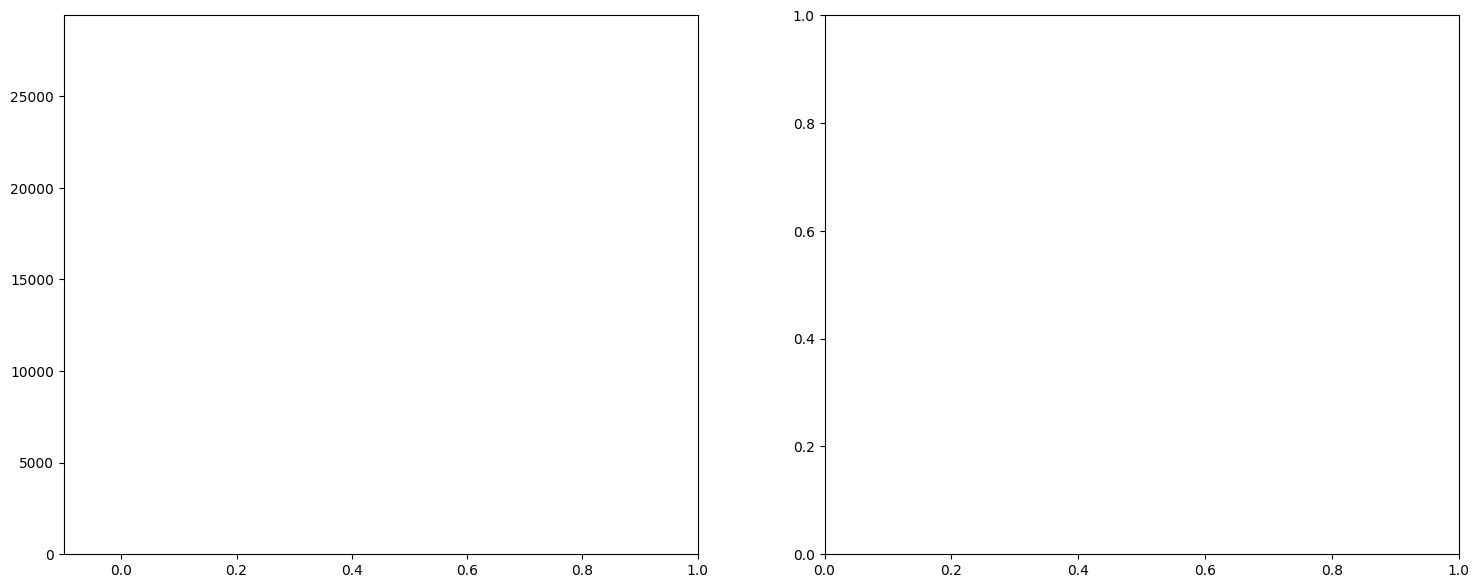

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
variable = "Mechanically ventilated"
all_anti = pd.merge(neg_bools, pos_bools, on= variable)
X = all_anti[variable].values.reshape(-1,1)
n_clusters = 2
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10, copy_x=False)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 0], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 0],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[0], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

In [ ]:
testpred = "../data/exp1/forecasting_preds/forecasting_preds_test/content/forecasting_preds_test.pkl"
testpreds = pd.read_pickle(testpred)


In [ ]:
testid = testpreds[0].drop_duplicates("ts_ind")
testid.loc[testid["sepsis_label"] == 1].sort_values(by=["SUBJECT_ID"])

,ts_ind,obs_window,SUBJECT_ID,sepsis_label,forecasting_pred,forecasting_test_op
13,88,20,85,1,"[0.4526701867580414, -0.6197700500488281, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,7,20,279,1,"[0.3193117380142212, -0.22587063908576965, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
131,678,20,405,1,"[0.2948346436023712, -0.048057764768600464, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
136,712,20,441,1,"[0.584531307220459, 2.4162402153015137, 1.4636...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
140,719,20,452,1,"[-0.6645195484161377, -0.033477216958999634, -...","[-0.3300797911612926, -0.29962675544042733, -0..."
...,...,...,...,...,...,...
8426,42901,20,99231,1,"[0.1330103725194931, -0.3165647089481354, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
8425,42900,20,99231,1,"[-0.3252127170562744, -0.16649511456489563, -0...","[-0.5632781791867781, -0.2971539555984116, -0...."
8451,43000,20,99312,1,"[-0.1290571093559265, 1.125860571861267, 0.865...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
8506,43274,20,99461,1,"[0.11790601909160614, -0.36471155285835266, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
